In [1]:
from matplotlib import font_manager, rc  # 한글사용 matplotlib
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import csv
import codecs
import numpy as np
import json
import tensorflow as tf
import jpype
import networkx as nx
from konlpy.tag import Okt
from IPython.core.interactiveshell import InteractiveShell
from pandas import DataFrame as df
InteractiveShell.ast_node_interactivity = 'all'
os.chdir("C:/Users/windd/pythondata")
%matplotlib inline
font_name = font_manager.FontProperties(
    fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# 훈련데이터 처리

In [48]:
df_afsnt = pd.read_csv('bigcontest/2019빅콘테스트_퓨처스리그2/AFSNT.csv',engine='python',encoding='cp949')
df_afsnt["STT"] = pd.to_datetime(df_afsnt["STT"], format = "%H:%M").dt.time
df_afsnt["ATT"] = pd.to_datetime(df_afsnt["ATT"], format = "%H:%M").dt.time

df_afsnt = df_afsnt.rename(columns={ 
    "SDT_YY": "year", "SDT_MM":"month", "SDT_DD":"day",  "SDT_DY":"wday", 
    "ARP":"origin", "ODP":"dest", 
    "FLO":"airline", "FLT":"flight" ,"REG":"tailnum", 
    "AOD":"is_arrive", 
    "IRR":"is_regular", 
    "STT":"sched_time", "ATT":"real_time", 
    "DLY":"is_delay", "DRR":"cause_delay", 
    "CNL":"is_cancel", "CNR":"cause_cancel"
})
df_afsnt["date"] = pd.to_datetime(df_afsnt[["year", "month", "day"]])
df_afsnt["sched_datetime"] = pd.to_datetime(df_afsnt['date'].astype(str) + " " + df_afsnt["scfhed_time"].astype(str))
df_afsnt["real_datetime"] = pd.to_datetime(df_afsnt['date'].astype(str) + " " + df_afsnt["real_time"].astype(str))

# delay 변수 생성
temp = df_afsnt["real_datetime"] - df_afsnt["sched_datetime"] 
temp = pd.DataFrame(temp.dt.components)
df_afsnt["delay"] = temp['minutes'] + 60 * temp['hours'] + 1440 * temp['days']
del temp

# 공항 테이블
df_afsnt['origin'] = df_afsnt['origin'].replace({
    'ARP1': '김포',
    'ARP2': '김해',
    'ARP3': '제주',
    'ARP4': '대구',
    'ARP5': '울산',
    'ARP6': '청주',
    'ARP7': '무안',
    'ARP8': '광주',
    'ARP9': '여수',
    'ARP10': '양양',
    'ARP11': '포항',
    'ARP12': '사천',
    'ARP13': '군산',
    'ARP14': '원주',
    'ARP15': '인천',    
})
df_afsnt['dest'] = df_afsnt['dest'].replace({
    'ARP1': '김포',
    'ARP2': '김해',
    'ARP3': '제주',
    'ARP4': '대구',
    'ARP5': '울산',
    'ARP6': '청주',
    'ARP7': '무안',
    'ARP8': '광주',
    'ARP9': '여수',
    'ARP10': '양양',
    'ARP11': '포항',
    'ARP12': '사천',
    'ARP13': '군산',
    'ARP14': '원주',
    'ARP15': '인천',    
})

# 항공사 테이블 
df_afsnt['airline'] = df_afsnt['airline'].replace({
    'A': '아시아나', 
    'I': '진에어',
    'J': '대한항공', 
    'F': '이스타',
    'H': '제주항공', 
    'L': '티웨이',
    'B': '에어부산', 
    'M': '코리아익스프레스에어'
})

# 결항 데이터 제거
# tailnum 널값 제거 4개 정도임 결항 제거하면
# ARP1 -> ARP1 으로 가는 이상 데이터 제거

df_afsnt = df_afsnt[df_afsnt['is_cancel']=='N']
df_afsnt = df_afsnt[~(df_afsnt['tailnum'].isnull())]
df_afsnt = df_afsnt[~((df_afsnt['origin']=='김포') & (df_afsnt['dest']=='김포'))]
df_afsnt = df_afsnt[(df_afsnt["airline"] != "C") & (df_afsnt["airline"] != "D") & (df_afsnt["airline"] != "K") & (df_afsnt["airline"] != "G") & \
         (df_afsnt["airline"] != "E")]


df_afsnt.index = list(range(len(df_afsnt)))

# 시간 범주화 함수 정의
def time_dicrete(stt):
    time_dic = []
    for i in range(len(stt)):
        st_base = str(stt[i])
        st = int(st_base.split(':')[0])*60 + int(st_base.split(':')[1])
        if st >= 300 and st < 480:
            time_dic.append('5시-8시')
        elif st >= 480 and st < 660:
            time_dic.append('8시-11시')
        elif st >= 660 and st < 840:
            time_dic.append('11시-14시')
        elif st >= 840 and st < 1020:
            time_dic.append('14시-17시')
        elif st >= 1020 and st < 1200:
            time_dic.append('17시-20시')
        elif st >= 1200 and st < 1380:
            time_dic.append('20시-23시')
        elif st >=1380 or st<300:
            time_dic.append('23시-3시')
    return time_dic  

stt = list(df_afsnt['sched_time'])

a = time_dicrete(stt)
df_afsnt['time_discrete'] = a

# 혼잡도 변수 생성
# +- 15/30분 기준으로 운행하는 비행기의 수

In [ ]:
# +- 30분 기준 혼잡도 변수 생성
# 오래걸림

# 출도착 구분

df_afsnt_d = df_afsnt[df_afsnt['is_arrive']=='D']
df_afsnt_a = df_afsnt[df_afsnt['is_arrive']=='A']

# 출발기준 혼잡도

df_afsnt_d = df_afsnt_d.sort_values(['origin','date','sched_time'])
df_afsnt_d.index = list(range(len(df_afsnt_d)))

base_time = datetime.timedelta(minutes=30)
congestion_d = []

for i in range(len(df_afsnt_d)):
    
    airport = df_afsnt_d['origin'][i]
    sched_time = df_afsnt_d['sched_datetime'][i]
    lower_time = sched_time - base_time
    upper_time = sched_time + base_time
    congestion_cnt = 0
    num = [x if x >= 0 else 0 for x in [i-30]]
    num2 = [x if x <= (len(df_afsnt_d)-30) else len(df_afsnt_d) for x in [i+30]]
    
    for j in range(num[0], num2[0],1):
        if (airport == df_afsnt_d['origin'][j]) and (lower_time <= df_afsnt_d['sched_datetime'][j]) and (df_afsnt_d['sched_datetime'][j] <= upper_time):
            congestion_cnt +=1
    congestion_d.append(congestion_cnt)
    
df_afsnt_d['congestion'] = congestion_d

# 도착 기준 혼잡도

df_afsnt_a = df_afsnt_a.sort_values(['dest','date','sched_time'])
df_afsnt_a.index = list(range(len(df_afsnt_a)))

base_time = datetime.timedelta(minutes=30)
congestion_a = []

for i in range(len(df_afsnt_a)):
    
    airport = df_afsnt_a['dest'][i]
    sched_time = df_afsnt_a['sched_datetime'][i]
    lower_time = sched_time - base_time
    upper_time = sched_time + base_time
    congestion_cnt = 0
    num = [x if x >= 0 else 0 for x in [i-30]]
    num2 = [x if x <= (len(df_afsnt_a)-30) else len(df_afsnt_a) for x in [i+30]]
    
    for j in range(num[0], num2[0],1):
        if (airport == df_afsnt_a['dest'][j]) and (lower_time <= df_afsnt_a['sched_datetime'][j]) and (df_afsnt_a['sched_datetime'][j] <= upper_time):
            congestion_cnt +=1
    congestion_a.append(congestion_cnt)
    
df_afsnt_a['congestion'] = congestion_a

# +- 15분 간격으로 혼잡도 변수 생성

# 출발기준 혼잡도

df_afsnt_d = df_afsnt_d.sort_values(['origin','date','sched_time'])
df_afsnt_d.index = list(range(len(df_afsnt_d)))

base_time = datetime.timedelta(minutes=15)
congestion_d = []

for i in range(len(df_afsnt_d)):
    
    airport = df_afsnt_d['origin'][i]
    sched_time = df_afsnt_d['sched_datetime'][i]
    lower_time = sched_time - base_time
    upper_time = sched_time + base_time
    congestion_cnt = 0
    num = [x if x >= 0 else 0 for x in [i-30]]
    num2 = [x if x <= (len(df_afsnt_d)-30) else len(df_afsnt_d) for x in [i+30]]
    
    for j in range(num[0], num2[0],1):
        if (airport == df_afsnt_d['origin'][j]) and (lower_time <= df_afsnt_d['sched_datetime'][j]) and (df_afsnt_d['sched_datetime'][j] <= upper_time):
            congestion_cnt +=1
    congestion_d.append(congestion_cnt)
    
df_afsnt_d['congestion_15'] = congestion_d

# 도착 기준 혼잡도

df_afsnt_a = df_afsnt_a.sort_values(['dest','date','sched_time'])
df_afsnt_a.index = list(range(len(df_afsnt_a)))

base_time = datetime.timedelta(minutes=15)
congestion_a = []

for i in range(len(df_afsnt_a)):
    
    airport = df_afsnt_a['dest'][i]
    sched_time = df_afsnt_a['sched_datetime'][i]
    lower_time = sched_time - base_time
    upper_time = sched_time + base_time
    congestion_cnt = 0
    num = [x if x >= 0 else 0 for x in [i-30]]
    num2 = [x if x <= (len(df_afsnt_a)-30) else len(df_afsnt_a) for x in [i+30]]
    
    for j in range(num[0], num2[0],1):
        if (airport == df_afsnt_a['dest'][j]) and (lower_time <= df_afsnt_a['sched_datetime'][j]) and (df_afsnt_a['sched_datetime'][j] <= upper_time):
            congestion_cnt +=1
    congestion_a.append(congestion_cnt)
    
df_afsnt_a['congestion_15'] = congestion_a

# 링크 및 air_sequence 변수 생성
# 링크는 동일 등록기호의 연결성을 파악하기 위한 번호(시간 기준으로 번호)
# air_sequence는 공항에서 시간순으로 정렬한 번호

In [ ]:
# 링크데이터를 위한 정렬

df_afsnt_sorted_d = df_afsnt_d.sort_values(['date','tailnum','sched_datetime'])
df_afsnt_sorted_a = df_afsnt_a.sort_values(['date','tailnum','sched_datetime'])

df_afsnt_sorted_d.index = list(range(len(df_afsnt_sorted_d)))
link_ref_d = df_afsnt_sorted_d.pivot_table(index = ['date','tailnum'],aggfunc='count',values='is_arrive' )
link_ref_list_d = list(link_ref_d['is_arrive'].values)

#linkdata - departure

link_d = []

for i in link_ref_list_d:
    link_range = list(range(i))
    link_d.append(link_range)
    
link_d = sum(link_d, [])
df_afsnt_sorted_d['link'] = link_d


df_afsnt_sorted_a.index = list(range(len(df_afsnt_sorted_a)))
link_ref_a = df_afsnt_sorted_a.pivot_table(index = ['date','tailnum'],aggfunc='count',values='is_arrive' )
link_ref_list_a = list(link_ref_a['is_arrive'].values)

#linkdata - arrival

link_a = []

for i in link_ref_list_a:
    link_range = list(range(i))
    link_a.append(link_range)
    
link_a = sum(link_a, [])
df_afsnt_sorted_a['link'] = link_a

df_afsnt = pd.concat([df_afsnt_sorted_d, df_afsnt_sorted_a], sort = False)

df_afsnt_d = df_afsnt[df_afsnt['is_arrive']=='D']
df_afsnt_a = df_afsnt[df_afsnt['is_arrive']=='A']
df_afsnt_d = df_afsnt_d.sort_values(['date','origin','sched_time'])
df_afsnt_a = df_afsnt_a.sort_values(['date','dest','sched_time'])

df_afsnt_d.index = list(range(len(df_afsnt_d)))
df_afsnt_a.index = list(range(len(df_afsnt_a)))

air_sequence = []
x = 0

for i in range(len(df_afsnt_d)):
    if i == 0:
        air_sequence.append(0)
    elif (df_afsnt_d['date'][i] == df_afsnt_d['date'][i-1]) and (df_afsnt_d['origin'][i] == df_afsnt_d['origin'][i-1]):
            if df_afsnt_d['sched_datetime'][i] > df_afsnt_d['sched_datetime'][i-1]:
                x +=1
                air_sequence.append(x)
            elif df_afsnt_d['sched_datetime'][i] == df_afsnt_d['sched_datetime'][i-1]:
                air_sequence.append(x)
            elif df_afsnt_d['sched_datetime'][i] < df_afsnt_d['sched_datetime'][i-1]:
                x = 0
                air_sequence.append(x)
    
    else :
        x = 0
        air_sequence.append(x)

df_afsnt_d['air_sequence'] = air_sequence

air_sequence = []
x = 0

for i in range(len(df_afsnt_a)):
    if i == 0:
        air_sequence.append(0)
    elif (df_afsnt_a['date'][i] == df_afsnt_a['date'][i-1]) and (df_afsnt_a['dest'][i] == df_afsnt_a['dest'][i-1]):
            if df_afsnt_a['sched_datetime'][i] > df_afsnt_a['sched_datetime'][i-1]:
                x +=1
                air_sequence.append(x)
            elif df_afsnt_a['sched_datetime'][i] == df_afsnt_a['sched_datetime'][i-1]:
                air_sequence.append(x)
            elif df_afsnt_a['sched_datetime'][i] < df_afsnt_a['sched_datetime'][i-1]:
                x = 0
                air_sequence.append(x)
    
    else :
        x = 0
        air_sequence.append(x)

df_afsnt_a['air_sequence'] = air_sequence

df_afsnt = pd.concat([df_afsnt_d, df_afsnt_a], sort = False)

# 중심성 분석 결과 변수 생성

In [ ]:
# 링크테이블

# 출발 링크테이블

df_afsnt_d = df_afsnt[df_afsnt['is_arrive']=='D']

link_table_d = df_afsnt_d.pivot_table(index=['origin','dest','link'],aggfunc='count',values='is_arrive')
link_table_d = link_table_d.reset_index(['origin','dest','link'])
link_table_d.columns = ['origin','dest','link','count']

# 도착 링크

df_afsnt_a = df_afsnt[df_afsnt['is_arrive']=='A']

link_table_a = df_afsnt_a.pivot_table(index=['origin','dest','link'],aggfunc='count',values='is_arrive')
link_table_a = link_table_a.reset_index(['origin','dest','link'])
link_table_a.columns = ['origin','dest','link','count']

# 전체 링크

link_table =  df_afsnt.pivot_table(index=['origin','dest','link'],aggfunc='count',values='is_arrive')
link_table = link_table.reset_index(['origin','dest','link'])
link_table.columns = ['origin','dest','link','count']


# 중심성 분석 함수
# 가중치 고려

def get_degree_centrality(df,arp) :
    N = 15
    Z = df[df['origin']==arp]['count'].sum()
    D = Z/(N-1)
    return D


# 가중치 고려 x

def degree_centrality(df,arp):
    N =15
    a = df[df['origin']==arp]
    D = len((a['origin']+','+a['dest']).unique())/(N-1)
    return D

# 중심성 분석 

arp_list = list(link_table_d['origin'].unique())
center_link_d = pd.DataFrame(data=arp_list,columns=['origin'])
D_list = []

for i in arp_list:
    D = get_degree_centrality(link_table_d, i)
    D_list.append(D)

center_link_d['degree_center_weight'] = D_list

# 가중치 고려x

N =15
arp_list = list(link_table_d['origin'].unique())
center_link2_d= pd.DataFrame(data=arp_list,columns=['origin'])
D_list = []

for i in arp_list:
    D = degree_centrality(link_table_d, i)
    D_list.append(D)
    
center_link2_d['degree_center'] = D_list

center_link_d_total = pd.merge(center_link_d, center_link2_d)

# 원 데이터에 매핑

ref_dict = {}

for i in range(len(center_link_d_total)):
    ref_dict[center_link_d_total['origin'][i]] = center_link_d_total['degree_center_weight'][i]
    
ref_dict2 = {}
for i in range(len(center_link_d_total)):
    ref_dict2[center_link_d_total['origin'][i]] = center_link_d_total['degree_center'][i]

df_afsnt_d['degree_center_weight_origin'] = df_afsnt_d['origin'].map(ref_dict)
df_afsnt_d['degree_center_weight_dest'] = df_afsnt_d['dest'].map(ref_dict)
df_afsnt_d['degree_center_origin'] = df_afsnt_d['origin'].map(ref_dict2)
df_afsnt_d['degree_center_dest'] = df_afsnt_d['dest'].map(ref_dict2)

# 중심성 분석 

arp_list = list(link_table_a['origin'].unique())
center_link_a = pd.DataFrame(data=arp_list,columns=['origin'])
D_list = []

for i in arp_list:
    D = get_degree_centrality(link_table_a, i)
    D_list.append(D)

center_link_a['degree_center_weight'] = D_list

# 가중치 고려x

N =15
arp_list = list(link_table_a['origin'].unique())
center_link2_a= pd.DataFrame(data=arp_list,columns=['origin'])
D_list = []

for i in arp_list:
    D = degree_centrality(link_table_a, i)
    D_list.append(D)
    
center_link2_a['degree_center'] = D_list
center_link_a_total = pd.merge(center_link_a, center_link2_a)

# 원데이터에 매핑

ref_dict = {}

for i in range(len(center_link_a_total)):
    ref_dict[center_link_a_total['origin'][i]] = center_link_a_total['degree_center_weight'][i]
    
ref_dict2 = {}
for i in range(len(center_link_a_total)):
    ref_dict2[center_link_a_total['origin'][i]] = center_link_a_total['degree_center'][i]

df_afsnt_a['degree_center_weight_origin'] = df_afsnt_a['origin'].map(ref_dict)
df_afsnt_a['degree_center_weight_dest'] = df_afsnt_a['dest'].map(ref_dict)
df_afsnt_a['degree_center_origin'] = df_afsnt_a['origin'].map(ref_dict2)
df_afsnt_a['degree_center_dest'] = df_afsnt_a['dest'].map(ref_dict2)

df_afsnt = pd.concat([df_afsnt_d,df_afsnt_a], sort = False)

# 항공 흐름 혼잡도 변수 생성
# 같은 노선에 혼잡정도를 파악

In [ ]:
# 항공흐름 혼잡도 / 출도착 구분 
# 오래걸림

df_afsnt['origin_dest'] = df_afsnt['origin']+','+df_afsnt['dest']
# 15분 전 항공흐름

# 출도착 구분

df_afsnt_d = df_afsnt[df_afsnt['is_arrive']=='D']
df_afsnt_a = df_afsnt[df_afsnt['is_arrive']=='A']

df_afsnt_d = df_afsnt_d.sort_values(['date','origin_dest','sched_time'])
df_afsnt_a = df_afsnt_a.sort_values(['date','origin_dest','sched_time'])

df_afsnt_d.index = list(range(len(df_afsnt_d)))

base_time = datetime.timedelta(minutes=15)
air_congestion_d = []

for i in range(len(df_afsnt_d)):
    
    airway = df_afsnt_d['origin_dest'][i]
    sched_time = df_afsnt_d['sched_datetime'][i]
    lower_time = sched_time - base_time
    upper_time = sched_time 
    air_congestion_cnt = 0
    num = [x if x >= 0 else 0 for x in [i-30]]
    num2 = [x if x <= (len(df_afsnt_d)-30) else len(df_afsnt_d) for x in [i+30]]
    
    for j in range(num[0], num2[0],1):
        if (airway == df_afsnt_d['origin_dest'][j]) and (lower_time <= df_afsnt_d['sched_datetime'][j]) and (df_afsnt_d['sched_datetime'][j] <= upper_time):
            air_congestion_cnt +=1
    air_congestion_d.append(air_congestion_cnt)
    
df_afsnt_d['air_congestion_15'] = air_congestion_d


df_afsnt_a.index = list(range(len(df_afsnt_a)))

base_time = datetime.timedelta(minutes=15)
air_congestion_a = []

for i in range(len(df_afsnt_a)):
    
    airway = df_afsnt_a['origin_dest'][i]
    sched_time = df_afsnt_a['sched_datetime'][i]
    lower_time = sched_time - base_time
    upper_time = sched_time 
    air_congestion_cnt = 0
    num = [x if x >= 0 else 0 for x in [i-30]]
    num2 = [x if x <= (len(df_afsnt_a)-30) else len(df_afsnt_a) for x in [i+30]]
    
    for j in range(num[0], num2[0],1):
        if (airway == df_afsnt_a['origin_dest'][j]) and (lower_time <= df_afsnt_a['sched_datetime'][j]) and (df_afsnt_a['sched_datetime'][j] <= upper_time):
            air_congestion_cnt +=1
    air_congestion_a.append(air_congestion_cnt)
    
df_afsnt_a['air_congestion_15'] = air_congestion_a

df_afsnt = pd.concat([df_afsnt_d, df_afsnt_a], sort= False)

# 항공흐름 혼잡도 / 출도착 구분 
# 30분 전 항공흐름

# 출도착 구분

df_afsnt_d = df_afsnt[df_afsnt['is_arrive']=='D']
df_afsnt_a = df_afsnt[df_afsnt['is_arrive']=='A']

df_afsnt_d = df_afsnt_d.sort_values(['date','origin_dest','sched_time'])
df_afsnt_a = df_afsnt_a.sort_values(['date','origin_dest','sched_time'])

df_afsnt_d.index = list(range(len(df_afsnt_d)))

base_time = datetime.timedelta(minutes=30)
air_congestion_d = []

for i in range(len(df_afsnt_d)):
    
    airway = df_afsnt_d['origin_dest'][i]
    sched_time = df_afsnt_d['sched_datetime'][i]
    lower_time = sched_time - base_time
    upper_time = sched_time 
    air_congestion_cnt = 0
    num = [x if x >= 0 else 0 for x in [i-30]]
    num2 = [x if x <= (len(df_afsnt_d)-30) else len(df_afsnt_d) for x in [i+30]]
    
    for j in range(num[0], num2[0],1):
        if (airway == df_afsnt_d['origin_dest'][j]) and (lower_time <= df_afsnt_d['sched_datetime'][j]) and (df_afsnt_d['sched_datetime'][j] <= upper_time):
            air_congestion_cnt +=1
    air_congestion_d.append(air_congestion_cnt)
    
df_afsnt_d['air_congestion_30'] = air_congestion_d


df_afsnt_a.index = list(range(len(df_afsnt_a)))

base_time = datetime.timedelta(minutes=30)
air_congestion_a = []

for i in range(len(df_afsnt_a)):
    
    airway = df_afsnt_a['origin_dest'][i]
    sched_time = df_afsnt_a['sched_datetime'][i]
    lower_time = sched_time - base_time
    upper_time = sched_time 
    air_congestion_cnt = 0
    num = [x if x >= 0 else 0 for x in [i-30]]
    num2 = [x if x <= (len(df_afsnt_a)-30) else len(df_afsnt_a) for x in [i+30]]
    
    for j in range(num[0], num2[0],1):
        if (airway == df_afsnt_a['origin_dest'][j]) and (lower_time <= df_afsnt_a['sched_datetime'][j]) and (df_afsnt_a['sched_datetime'][j] <= upper_time):
            air_congestion_cnt +=1
    air_congestion_a.append(air_congestion_cnt)
    
df_afsnt_a['air_congestion_30'] = air_congestion_a

df_afsnt = pd.concat([df_afsnt_d, df_afsnt_a], sort= False)

# 항공사별 비행기의 평균 연결정도 변수 파악

In [ ]:
# 항공사의 일별 연결정도 변수

df_afsnt_d = df_afsnt[df_afsnt['is_arrive']=='D']
df_afsnt_a = df_afsnt[df_afsnt['is_arrive']=='A']

# 출도착 일별 평균 비행기 개수

d = df_afsnt_d.pivot_table(index = ['date', 'airline','tailnum'], aggfunc = 'count', values = 'is_arrive')
d = d.reset_index(['date','airline','tailnum'])
d2 = d.pivot_table(index = ['date','airline'], aggfunc = 'count', values = 'tailnum')
d2 = d2.reset_index(['date','airline'])
dd =d2.pivot_table(index = 'airline', aggfunc = 'mean', values = 'tailnum')
dd = dd.reset_index(['airline'])
dd.columns = ['airline','count']

a = df_afsnt_a.pivot_table(index = ['date', 'airline','tailnum'], aggfunc = 'count', values = 'is_arrive')
a = a.reset_index(['date','airline','tailnum'])
a2 = a.pivot_table(index = ['date','airline'], aggfunc = 'count', values = 'tailnum')
a2 = a2.reset_index(['date','airline'])
aa =a2.pivot_table(index = 'airline', aggfunc = 'mean', values = 'tailnum')
aa = aa.reset_index(['airline'])
aa.columns = ['airline','count']


x = df_afsnt_d.pivot_table(index = ['date','airline'],aggfunc = 'count', values = 'is_arrive')
x = x.reset_index(['date','airline'])
x.columns = ['date','airline','count']

y = df_afsnt_a.pivot_table(index = ['date','airline'],aggfunc = 'count', values = 'is_arrive')
y = y.reset_index(['date','airline'])
y.columns = ['date','airline','count']

link_count = []
for i in range(len(x)):
    a = x['count'][i]
    b = float(dd[dd['airline']==x['airline'][i]]['count'].values)
    cnt = a/b
    link_count.append(cnt)
x['link_count'] = link_count

link_count = []
for i in range(len(y)):
    a = y['count'][i]
    b = float(aa[aa['airline']==y['airline'][i]]['count'].values)
    cnt = a/b
    link_count.append(cnt)
y['link_count'] = link_count

x = x.drop(columns = 'count')
y = y.drop(columns = 'count')

df_afsnt_d = pd.merge(df_afsnt_d,x, on = ['date','airline'])
df_afsnt_a = pd.merge(df_afsnt_a, y, on = ['date','airline'])

df_afsnt = pd.concat([df_afsnt_d, df_afsnt_a], sort = False)

# 항공사별 시간순 변수 생성

In [ ]:
# 항공사별 sequence 생성

df_afsnt_d = df_afsnt[df_afsnt['is_arrive']=='D']
df_afsnt_a = df_afsnt[df_afsnt['is_arrive']=='A']

df_afsnt_d = df_afsnt_d.sort_values(['date','airline','sched_time'])
df_afsnt_a = df_afsnt_a.sort_values(['date','airline','sched_time'])

df_afsnt_d.index = list(range(len(df_afsnt_d)))
df_afsnt_a.index = list(range(len(df_afsnt_a)))

# 출발

air_link = []
x = 0

for i in range(len(df_afsnt_d)):
    if i == 0:
        air_link.append(0)
    
    elif df_afsnt_d['sched_datetime'][i] > df_afsnt_d['sched_datetime'][i-1]:
        if df_afsnt_d['day'][i] == df_afsnt_d['day'][i-1]:
            x += 1
            air_link.append(x)
        elif df_afsnt_d['day'][i] > df_afsnt_d['day'][i-1]:
            x = 0
            air_link.append(x)
        elif df_afsnt_d['day'][i] < df_afsnt_d['day'][i-1]:
            x = 0
            air_link.append(x)
        
    elif df_afsnt_d['sched_datetime'][i] == df_afsnt_d['sched_datetime'][i-1]:
        air_link.append(x)
        
    elif df_afsnt_d['sched_datetime'][i] < df_afsnt_d['sched_datetime'][i-1]:
        x = 0
        air_link.append(x)

df_afsnt_d['air_link'] = air_link

# 도착

air_link = []
x = 0

for i in range(len(df_afsnt_a)):
    if i == 0:
        air_link.append(0)
    
    elif df_afsnt_a['sched_datetime'][i] > df_afsnt_a['sched_datetime'][i-1]:
        if df_afsnt_a['day'][i] == df_afsnt_a['day'][i-1]:
            x += 1
            air_link.append(x)
        elif df_afsnt_a['day'][i] > df_afsnt_a['day'][i-1]:
            x = 0
            air_link.append(x)
        elif df_afsnt_a['day'][i] < df_afsnt_a['day'][i-1]:
            x = 0
            air_link.append(x)
        
    elif df_afsnt_a['sched_datetime'][i] == df_afsnt_a['sched_datetime'][i-1]:
        air_link.append(x)
        
    elif df_afsnt_a['sched_datetime'][i] < df_afsnt_a['sched_datetime'][i-1]:
        x = 0
        air_link.append(x)
        

df_afsnt_a['air_link'] = air_link


# 공항별 항공사별 sequence 생성

df_afsnt_d = df_afsnt_d.sort_values(['date','origin','airline','sched_time'])
df_afsnt_a = df_afsnt_a.sort_values(['date','dest','airline','sched_time'])

df_afsnt_d.index = list(range(len(df_afsnt_d)))
df_afsnt_a.index = list(range(len(df_afsnt_a)))

air_place_link = []
x = 0

for i in range(len(df_afsnt_d)):
    if i == 0:
        air_place_link.append(0)
    
    elif (df_afsnt_d['origin'][i] == df_afsnt_d['origin'][i-1]) and (df_afsnt_d['date'][i] == df_afsnt_d['date'][i-1]) and (df_afsnt_d['airline'][i] == df_afsnt_d['airline'][i-1]):
        if df_afsnt_d['sched_datetime'][i] > df_afsnt_d['sched_datetime'][i-1]:
            x += 1
            air_place_link.append(x)
        elif df_afsnt_d['sched_datetime'][i] == df_afsnt_d['sched_datetime'][i-1]:
            air_place_link.append(x)
        elif df_afsnt_d['sched_datetime'][i] < df_afsnt_d['sched_datetime'][i-1]:
            x = 0
            air__placelink.append(x)
        
    else :
        x = 0
        air_place_link.append(x)

df_afsnt_d['air_place_link'] = air_place_link

air_place_link = []
x = 0

for i in range(len(df_afsnt_a)):
    if i == 0:
        air_place_link.append(0)
    
    elif (df_afsnt_a['dest'][i] == df_afsnt_a['dest'][i-1]) and (df_afsnt_a['date'][i] == df_afsnt_a['date'][i-1]) and (df_afsnt_a['airline'][i] == df_afsnt_a['airline'][i-1]):
        if df_afsnt_a['sched_datetime'][i] > df_afsnt_a['sched_datetime'][i-1]:
            x += 1
            air_place_link.append(x)
        elif df_afsnt_a['sched_datetime'][i] == df_afsnt_a['sched_datetime'][i-1]:
            air_place_link.append(x)
        elif df_afsnt_a['sched_datetime'][i] < df_afsnt_a['sched_datetime'][i-1]:
            x = 0
            air__placelink.append(x)
        
    else :
        x = 0
        air_place_link.append(x)

df_afsnt_a['air_place_link'] = air_place_link

df_afsnt = pd.concat([df_afsnt_d, df_afsnt_a], sort = False)

# 거리, 공항 관련 데이터(부지면적, 활주로 등), 거리중심성 변수 생성

In [ ]:
# 거리 매핑 및 거리중심성 

distance = pd.read_csv('bigcontest/airport_distance.csv', engine = 'python', encoding = 'cp949')
distance['origin_dest'] = distance['origin']+','+distance['dest']
df_afsnt['origin_dest'] = df_afsnt['origin']+','+df_afsnt['dest']

ref_dict = {}

for i in range(len(distance)):
    ref_dict[distance['origin_dest'][i]] = distance['distance_km'][i]

df_afsnt['distance_km'] = df_afsnt['origin_dest'].map(ref_dict)

G = nx.from_pandas_edgelist(df_afsnt, source = "origin", target= "dest")
closeness_centrality = nx.closeness_centrality(G)
node, BC = zip(*closeness_centrality.items())
center = pd.DataFrame({'origin':node, 'distance_center':BC}).sort_values(by='distance_center',ascending=False)


# 매핑

ref_dict = {}

for i in range(len(center)):
    ref_dict[center['origin'][i]] = center['distance_center'][i]

df_afsnt['distance_center'] = df_afsnt['origin'].map(ref_dict)

# 거리중심성 분석
# 어떤 테이블이 있을건데 이것은 출발 - 도착 - 거리를 보여주는 데이터프레임 = df_distance 

origin_unique = (df_afsnt['origin']).unique()

def get_distance_centrality(origin):
    N = 15
    df_distance = distance[distance['origin']==origin]
    df_distance.index = list(range(len(df_distance)))
    distance_sum = 0
    for i in range(len(df_distance)):
        distance_sum += df_distance['distance_km'][i]
            
    distance_sum_inverse = (distance_sum)**(-1)
    distance_center = (N-1)*distance_sum_inverse
    return distance_center 

# 중심성 분석 

origin_unique = (df_afsnt['origin']).unique()
center_distance = pd.DataFrame(data=origin_unique,columns=['origin'])
D_list = []

for i in origin_unique:
    D = get_distance_centrality(i)
    D_list.append(D)

center_distance['distance_center'] = D_list

ref_dict = {}

for i in range(len(center_distance)):
    ref_dict[center_distance['origin'][i]] = center_distance['distance_center'][i]

df_afsnt['distance_center_weight'] = df_afsnt['origin'].map(ref_dict)

# 공항정보 매핑

info = pd.read_csv('bigcontest/공항활주로_부지면적.csv', engine='python',encoding='cp949')
df_afsnt = pd.merge(df_afsnt, info, on=['origin','year'])
df_afsnt = df_afsnt.drop(columns = ['origin_dest'])

# 하루당 동일 비행기의 운행횟수 변수

In [ ]:
# 하루당 해당 비행기 운행횟수

df_afsnt_d = df_afsnt[df_afsnt['is_arrive']=='D']
df_afsnt_a = df_afsnt[df_afsnt['is_arrive']=='A']

d_table = df_afsnt_d.pivot_table(index=['date','tailnum'],aggfunc='count',values='is_arrive')
d_table = d_table.reset_index(['date','tailnum'])
d_table.columns = ['date','tailnum','cnt_per_day']

a_table = df_afsnt_a.pivot_table(index=['date','tailnum'],aggfunc='count',values='is_arrive')
a_table = a_table.reset_index(['date','tailnum'])
a_table.columns = ['date','tailnum','cnt_per_day']

df_afsnt_d2 = pd.merge(df_afsnt_d, d_table, on = ['date','tailnum'])
df_afsnt_a2 = pd.merge(df_afsnt_a, a_table, on = ['date','tailnum'])

df_afsnt = pd.concat([df_afsnt_d2,df_afsnt_a2], sort = False)

# 공항 관련 데이터, 시간 데이터 추가

In [ ]:
df_afsnt['is_flight_T'] = np.where(df_afsnt['flight'].str.endswith("T"), 1, 0)
df_afsnt['is_flight_M'] = np.where(df_afsnt['flight'].str.endswith("M"), 1, 0)
df_afsnt['is_flight_F'] = np.where(df_afsnt['flight'].str.endswith("F"), 1, 0)

import datetime as dt

df_afsnt['sched_datetime'] = pd.to_datetime(df_afsnt['sched_datetime'])

# 월
df_afsnt['month_sin'] = np.sin(2*df_afsnt['sched_datetime'].dt.month*np.pi / 12 )
df_afsnt['month_cos'] = np.cos(2*df_afsnt['sched_datetime'].dt.month*np.pi / 12 )

# 요일
df_afsnt['sched_datetime'] = pd.to_datetime(df_afsnt['sched_datetime'])
df_afsnt['is_weekend'] = np.where((df_afsnt['sched_datetime'].dt.weekday == 6) | (df_afsnt['sched_datetime'].dt.weekday == 5), True, False)

# 시간
df_afsnt['time_sin'] = 60 * np.sin(2*np.pi*df_afsnt['sched_datetime'].dt.hour / 24) + \
                        np.sin(2*df_afsnt['sched_datetime'].dt.minute*np.pi / 60)
df_afsnt['time_cos'] = 60 * np.cos(2*df_afsnt['sched_datetime'].dt.hour*np.pi / 24) + \
                        np.cos(2*np.pi*df_afsnt['sched_datetime'].dt.minute / 60)




# 해발 고도
df_altitude = pd.DataFrame(pd.Series({
    '김포': 18,
    '김해': 4,
    '제주': 36,
    '대구': 35.4,
    '울산': 12.9,
    '청주': 58,
    '양양': 73.5,
    '무안': 23.7,
    '광주': 12.8,
    '여수': 20,
    '사천': 7.6,
    '포항': 21.3,
    '군산': 8.8,
    '원주': 100,
    '인천': 7
})).reset_index().rename(columns = {'index': 'airport', 0: 'alt'})

df_afsnt = pd.merge(df_afsnt, df_altitude, how = "left", left_on = 'origin', right_on = 'airport', suffixes = ('_origin', '_dest'))
df_afsnt = pd.merge(df_afsnt, df_altitude, how = "left", left_on = 'dest', right_on = 'airport', suffixes = ('_origin', '_dest'))
df_afsnt.drop(['airport_origin', 'airport_dest'], axis = 1, inplace = True)


# is_변수 True False로 변환
df_afsnt["is_arrive"] = np.where(df_afsnt["is_arrive"] == "A", True, False)
df_afsnt["is_regular"] = np.where(df_afsnt["is_regular"] == "Y", True, False)
df_afsnt["is_delay"] = np.where(df_afsnt["is_delay"] == "Y", True, False)

# 추가 변수들
df_afsnt['origin_dest'] = df_afsnt['origin'] + '_' + df_afsnt['dest']



# 황금연휴 추가

df_afsnt['is_goldentime'] = df_afsnt['date'].isin(["2017-01-26", "2017-01-27", "2017-01-28", "2017-01-29", "2017-01-30", "2017-01-31", "2017-05-05", "2017-05-06", "2017-05-07", "2017-08-15",
 "2017-09-29", "2017-09-30", "2017-10-01", "2017-10-02", "2017-10-03", "2017-10-04", "2017-10-05", "2017-10-06", "2017-10-07", "2017-10-08", "2017-10-09", "2017-10-10", 
                                                   "2017-12-25", "2018-01-01", "2018-02-14", "2018-02-15", "2018-02-16", "2018-02-17", "2018-02-18", "2018-02-19", "2018-03-01",
 "2018-05-05", "2018-05-07", "2018-05-22",
 "2018-06-06", "2018-06-13", "2018-08-15", "2018-09-21", "2018-09-22", "2018-09-23", "2018-09-24", "2018-09-25", "2018-09-26", "2018-09-27", 
 "2018-10-03", "2018-10-09", "2018-12-25", 
 "2019-01-01", "2019-02-01", "2019-02-02", "2019-02-03", "2019-02-04", "2019-02-05", "2019-02-06", "2019-02-07",
 "2019-03-01", "2019-05-04", "2019-05-05", "2019-05-06"])

# 전비행기와의 시간차 및 거리대비 시간차 변수 생성

In [ ]:
# 연결 비행기에 있어서 전 비행기와의 시간차이 및 거리를 고려한 시간차이 


df_afsnt_d = df_afsnt[df_afsnt['is_arrive']==False]
df_afsnt_a = df_afsnt[df_afsnt['is_arrive']==True]

# 출발인경우

df_afsnt_d_sorted = df_afsnt_d.sort_values(['date','tailnum','sched_time'])
df_afsnt_d_sorted.index = list(range(len(df_afsnt_d_sorted)))

time_diff = []
time_diff_distance = []

for i in range(len(df_afsnt_d_sorted)):
    if df_afsnt_d_sorted['link'][i] == 0 :
        time_diff.append(0)
        time_diff_distance.append(0)
        
    elif df_afsnt_d_sorted['tailnum'][i] != df_afsnt_d_sorted['tailnum'][i-1]:
        time_diff.append(0)
        time_diff_distance.append(0)
        
    else :
        time_diff_sec = (df_afsnt_d_sorted['sched_datetime'][i] - df_afsnt_d_sorted['sched_datetime'][i-1]).seconds
        time_diff_min = int(time_diff_sec/60)
        time_diff.append(time_diff_min)
        
        time_diff_dis = time_diff_min/df_afsnt_d_sorted['distance_km'][i-1]
        time_diff_distance.append(time_diff_dis)
        
df_afsnt_d_sorted['time_diff'] = time_diff
df_afsnt_d_sorted['time_diff_distance'] = time_diff_distance

# 도착인경우

df_afsnt_a_sorted = df_afsnt_a.sort_values(['date','tailnum','sched_time'])
df_afsnt_a_sorted.index = list(range(len(df_afsnt_a_sorted)))

time_diff = []
time_diff_distance = []

for i in range(len(df_afsnt_a_sorted)):
    if df_afsnt_a_sorted['link'][i] == 0 :
        time_diff.append(0)
        time_diff_distance.append(0)
        
    elif df_afsnt_a_sorted['tailnum'][i] != df_afsnt_a_sorted['tailnum'][i-1]:
        time_diff.append(0)
        time_diff_distance.append(0)
        
    else :
        time_diff_sec = (df_afsnt_a_sorted['sched_datetime'][i] - df_afsnt_a_sorted['sched_datetime'][i-1]).seconds
        time_diff_min = int(time_diff_sec/60)
        time_diff.append(time_diff_min)
        
        time_diff_dis = time_diff_min/df_afsnt_a_sorted['distance_km'][i-1]
        time_diff_distance.append(time_diff_dis)
        
df_afsnt_a_sorted['time_diff'] = time_diff
df_afsnt_a_sorted['time_diff_distance'] = time_diff_distance
df_afsnt = pd.concat([df_afsnt_d_sorted, df_afsnt_a_sorted], sort = False)

# 항공편 지연비율 매핑 변수

In [ ]:
df_afsnt_d = df_afsnt[df_afsnt['is_arrive']==False]
df_afsnt_a = df_afsnt[df_afsnt['is_arrive']==True]

d_x = df_afsnt_d[df_afsnt_d['is_delay']==True].pivot_table(index = 'flight', aggfunc = 'count', values ='is_arrive')
d_y = df_afsnt_d.pivot_table(index = 'flight', aggfunc = 'count', values ='is_arrive')
a_x = df_afsnt_a[df_afsnt_a['is_delay']==True].pivot_table(index = 'flight', aggfunc = 'count', values ='is_arrive')
a_y = df_afsnt_a.pivot_table(index = 'flight', aggfunc = 'count', values ='is_arrive')

d = d_x/d_y
d = d.reset_index('flight')
d.columns  = ['flight','dly_por']
a = a_x/a_y
a = a.reset_index('flight')
a.columns = ['flight','dly_por']

d.fillna(d['dly_por'].mean(),inplace=True)
a.fillna(a['dly_por'].mean(),inplace=True)

df_afsnt_d = pd.merge(df_afsnt_d, d, on = 'flight')
df_afsnt_a = pd.merge(df_afsnt_a, a, on = 'flight')
df_afsnt = pd.concat([df_afsnt_d, df_afsnt_a], sort=False)

df_afsnt.to_csv('bigcontest/df_afsnt_total_ver10.csv', index = False, encoding = 'cp949')

# Modeling

In [7]:
df_afsnt = pd.read_csv('bigcontest/df_afsnt_total_ver10.csv', encoding = 'cp949')

In [8]:
# 시간정렬
df_afsnt = df_afsnt.sort_values(['year', 'month', 'day'], ascending=[True, True, True])
df_afsnt = df_afsnt.reset_index()
df_afsnt.drop('index', axis = 1, inplace = True)

In [9]:
# 범주형 변수 처리
# 무의미한 변수 제거

df_afsnt_total = df_afsnt
df_afsnt_total = df_afsnt_total.drop(['month','day','flight','origin','dest','cause_cancel','tailnum','cause_delay','sched_time','real_time',
        'is_cancel','sched_datetime','real_datetime','delay','origin_dest','time_discrete'], axis=1)

# 요일
encoded = pd.get_dummies(df_afsnt_total.wday)
df_afsnt_total = pd.concat([df_afsnt_total, encoded], axis=1)
df_afsnt_total.drop('wday', axis = 1, inplace = True)

# 항공사
encoded = pd.get_dummies(df_afsnt_total.airline)
df_afsnt_total = pd.concat([df_afsnt_total, encoded], axis=1)
df_afsnt_total.drop('airline', axis = 1, inplace = True)


#time_discrete
#encoded = pd.get_dummies(df_afsnt_total.time_discrete)
#df_afsnt_total = pd.concat([df_afsnt_total, encoded], axis=1)
#df_afsnt_total.drop('time_discrete', axis = 1, inplace = True)


# is_arrive
encoded = pd.get_dummies(df_afsnt_total.is_arrive)
df_afsnt_total = pd.concat([df_afsnt_total, encoded], axis=1)
df_afsnt_total.drop('is_arrive', axis = 1, inplace = True)

# is_regular
encoded = pd.get_dummies(df_afsnt_total.is_regular)
df_afsnt_total = pd.concat([df_afsnt_total, encoded], axis=1)
df_afsnt_total.drop('is_regular', axis = 1, inplace = True)

In [10]:
# Train, Validation, Test Set 분할

train = df_afsnt_total[df_afsnt_total['date']<'2019-06']
test = df_afsnt_total[df_afsnt_total['date']>'2019-06']
train.drop('date', axis = 1, inplace = True)
test.drop('date', axis = 1, inplace = True)

X_train = train.drop(['is_delay'],axis=1)
y_train = train['is_delay']

X_test = test.drop(['is_delay'], axis = 1)
y_test = test['is_delay']

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [11]:
# Time CV Class
# 시계열 데이터 특성을 고려하기 위해서 CV 객체 생성

class TimeKfold():
    def __init__(self, n_splits):
        self.n_splits = n_splits
        
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    def split(self, X, y = None, groups = None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)
        
        # fold마다 validation set을 지정함
        start = 0
        stop = 0 
        mid = [162229, 363661, 555336, 753742, 912315]
        stop = [195609, 395673, 588621, 786309, 946279]
        for i in range(self.n_splits):
            yield indices[start:mid[i]], indices[mid[i]: stop[i]]

tscv = TimeKfold(n_splits= 5)

In [3]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgb
import sklearn.metrics as mt
from yellowbrick.classifier import ROCAUC
import pickle
from sklearn.externals import joblib

C:\Users\windd\AppData\Roaming\Python\Python36\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# 파라미터 튜닝 시 Grid search 활용
# 양 끝점이 선택되면 그 점을 기준으로 다시 진행
# 이를 추정하는 과정은 생략하고 마지막으로 선택된 파라미터에서 학습하는 것만 작성했음

In [ ]:
# Random Forest 최종 학습
"""clf_rf = RandomForestClassifier(random_state = 100)

param_grid = {
    'n_estimators': [500],
    'max_depth': [11],
    'max_features': [12],
    'class_weight': ['balanced']
}   

gsearch = GridSearchCV(estimator = clf_rf, cv = tscv,
                param_grid = param_grid, scoring= 'roc_auc')
%time gsearch.fit(X_train, y_train)"""

In [4]:
# 모델 저장

# joblib.dump(gsearch.best_estimator_,'bigcontest/clf_rf.pkl')


# best parameter로 학습된 모델 불러오기 

clf_rf = joblib.load('bigcontest/clf_rf1.pkl')

In [16]:
# 테스트 성능평가

y_pred = clf_rf.predict(X_test)
y_prob = clf_rf.predict_proba(X_test)
auc = mt.roc_auc_score(y_test,y_prob[:,1])

print('AUC: ', auc)
print('Accuracy: ',clf_rf.score(X_test, y_test))

AUC:  0.8115185203485905
Accuracy:  0.9126342464100399


C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


0.8115479626174318

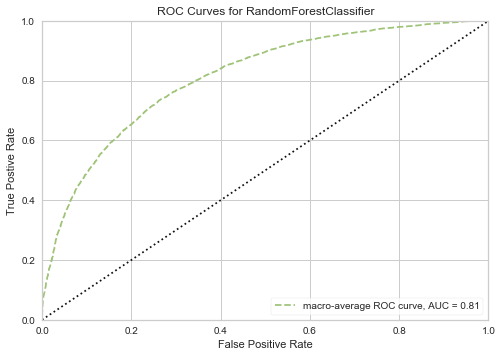

In [17]:
visualizer = ROCAUC(clf_rf, classes=[False, True], micro=False, macro=True, per_class=False)
visualizer.score(X_test, y_test)
visualizer.show()

In [28]:
pd.DataFrame({'속성':X_train.columns, '중요도':clf_rf.feature_importances_}).sort_values('중요도', ascending =False)

,속성,중요도
34,dly_por,0.327176
33,time_diff_distance,0.115934
32,time_diff,0.114638
50,True,0.060457
49,False,0.051080
2,link,0.035997
27,time_sin,0.032767
3,air_sequence,0.031261
8,link_count,0.022712
9,air_link,0.021195


In [ ]:
# KNN

"""clf_knn = KNeighborsClassifier(random_state = 100)

param_grid = {
    'n_neighbors': [70],
    'weights': ['distance'],
    'metric': ['manhattan']
}

gsearch = GridSearchCV(estimator= clf_knn, param_grid = param_grid, scoring = 'roc_auc', cv= tscv)
%time gsearch.fit(X_train, y_train)"""

In [18]:
# 모델 저장

# joblib.dump(gsearch.best_estimator_,'bigcontest/clf_knn.pkl')

clf_knn = joblib.load('bigcontest/clf_knn.pkl')

In [19]:
# 테스트 성능평가

y_pred = clf_knn.predict(X_test)
y_prob = clf_knn.predict_proba(X_test)
auc = mt.roc_auc_score(y_test,y_prob[:,1])

print('AUC: ', auc)
print('Accuracy: ',clf_knn.score(X_test, y_test))

AUC:  0.8046689184907017
Accuracy:  0.9120610594907687


C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


0.8047036630544561

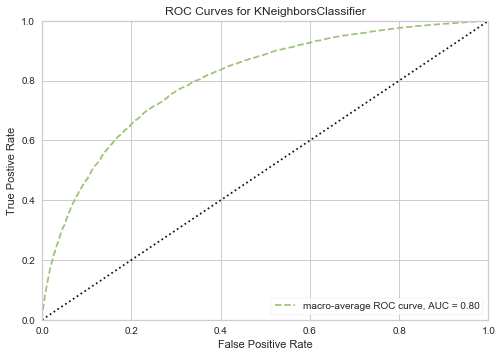

In [20]:
visualizer = ROCAUC(clf_knn, classes=[False, True], micro=False, macro=True, per_class=False)
visualizer.score(X_test, y_test)
visualizer.show()

In [ ]:
# LightGBM

"""clf_lgb = lgb.LGBMClassifier(random_state = 100)

param_grid = {
    'boosting_type': ['dart'],
    'max_depth': [19],
    'n_estimators': [2000],
    'colsample_by_tree': [0.6],
    'class_weight': ['balanced'],
    'learning_rate': [0.04],
    'num_leaves': [35]
}

gsearch = GridSearchCV(estimator= clf_lgb, param_grid = param_grid, scoring = 'roc_auc', cv= tscv
                     )
%time gsearch.fit(X_train, y_train)"""

In [21]:
#joblib.dump(gsearch.best_estimator_,'bigcontest/clf_lgb.pkl')

clf_lgb = joblib.load('bigcontest/clf_lgb.pkl')

In [27]:
y_pred = clf_lgb.predict(X_test)
y_prob = clf_lgb.predict_proba(X_test)
auc = mt.roc_auc_score(y_test,y_prob[:,1])

print('AUC: ', auc)
print('Accuracy: ', clf_lgb.score(X_test, y_test))

AUC:  0.8094222991807285
Accuracy:  0.816188005309521


C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


0.8094488502023324

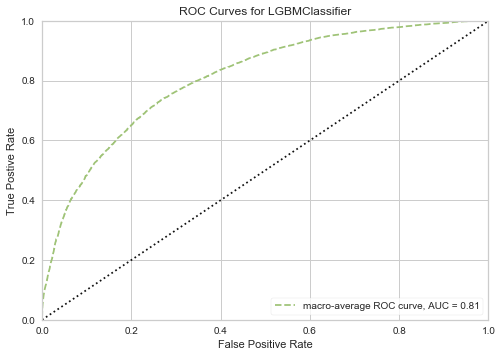

In [10]:
visualizer = ROCAUC(gsearch.best_estimator_, classes=[False, True], micro=False, macro=True, per_class=False)
visualizer.score(X_test, y_test)
visualizer.show()

In [30]:
pd.DataFrame({'속성':X_train.columns, '중요도':clf_lgb.feature_importances_}).sort_values('중요도', ascending =False)

,속성,중요도
34,dly_por,8705
8,link_count,7081
32,time_diff,6712
33,time_diff_distance,4951
24,month_sin,4244
25,month_cos,3582
2,link,2901
0,year,2873
27,time_sin,2381
20,cnt_per_day,2305
